In [5]:
%%bash
# This notebook is organized as a slide show, 
# run this cell to display the interactive slides
jupyter nbconvert NUS.ipynb --to slides
mv NUS.slides.html files/
cd files; python -m nbconvert.postprocessors.serve NUS.slides.html

Process is interrupted.


In [3]:
%pylab inline
plt.style.use('seaborn-talk')
mpl.rcParams['image.cmap']= u'coolwarm'

Populating the interactive namespace from numpy and matplotlib


# Non Uniform Sampling
### 1) Principle / Motivations
### 2) Processing
### 3) Compressed Sensing

## Principles
The length of an acquisition in Fourier Spectroscopy is governed by several parameters:
 - sampling rate $SR$ determines the maximal frequency $F_{max}$ and the spectral width $SW$ by the Nyquist theorem
 $$
  F_{max} = \frac 1 2 SR \\
 \Rightarrow  SW = [0 \ldots F_{max}] = \frac 1 2 SR \quad \text{in real mode} \\
 \Rightarrow  SW = [-F_{max} \ldots F_{max}] = SR  \quad \text{in complex mode}
 $$
 
 - The acquisition time $AQ$ is related to $SR$ and to the number $N$ of points
 $$
 AQ = N \Delta t = \frac {N}{SR}
 $$
 
 - The Frequency resolution depends on these quantities:
 $$
 \Delta F = \frac {SW}{N} = \frac {1}{AQ}
 $$

## In 2D 
In 2D, $t_1$ and $t_2$ are very asymmetric. Each points in the $t_1$ axis requires the acquisition of one (2 if hypercomplex) full experiment.
 - $t_2$ is a date
 - $t_1$ is a delay

We want to go as fast as possible $\Rightarrow$ smallest $N_1$, as total acquisition time is proportionnal to $N_1$

We want to have highest possible resolution $\Rightarrow$ highest $\Delta F$ $\Rightarrow$ largest $AQ_1$ $\Rightarrow$ largest $N_1$

Incompatible ?

## Example in 1D

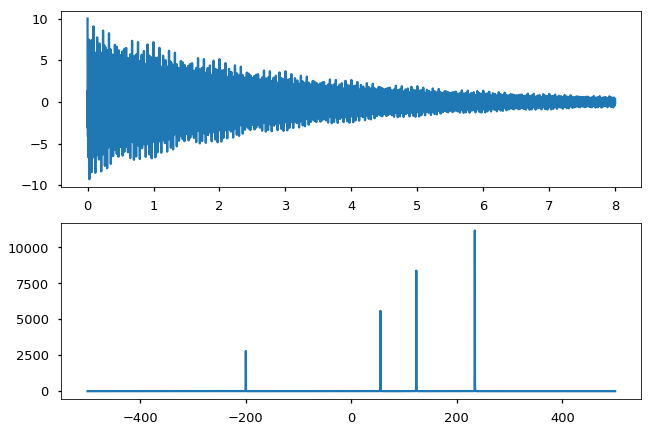

In [7]:
N = 8000
SR = 1000.0
dt = 1/SR
freq = [-200.0, 55, 123,  234]
amp = [1,2,3,4]
tau = 3.0

tp = arange(0,N)*dt
fq = linspace(-SR/2,SR/2,N)

fid = zeros(N, dtype=complex)
for a,nu in zip(amp, freq):
    fid += a*exp(-tp/tau)*exp(2j*pi*nu*tp)
subplot(211)
plot(tp, fid.real)

def FT(v):
    return  fftshift(fft.fft(v))
subplot(212)
plot(fq, FT(fid).real )

## Sampling

Text(0.5,1,'cumulative of the sampling')

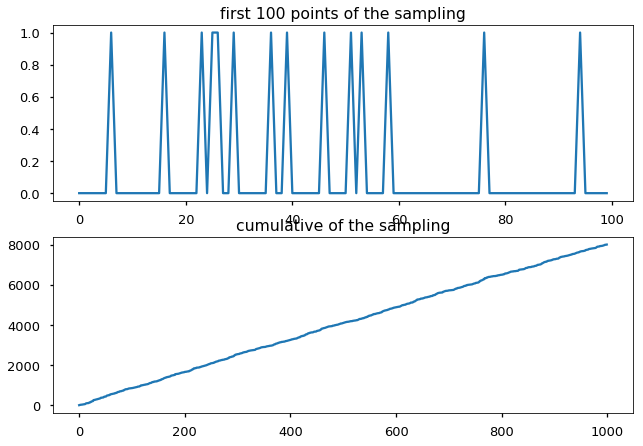

In [25]:
RATIO = 1./8
perm = np.random.permutation(N)  # generate a permutation 
sampling = sorted(perm[:int(N*RATIO)])
x = zeros(N)
x[sampling] = 1.0
subplot(211); plot(x[:100]); title('first 100 points of the sampling')
subplot(212); plot(sampling); title('cumulative of the sampling')

## Sampling as a convolution

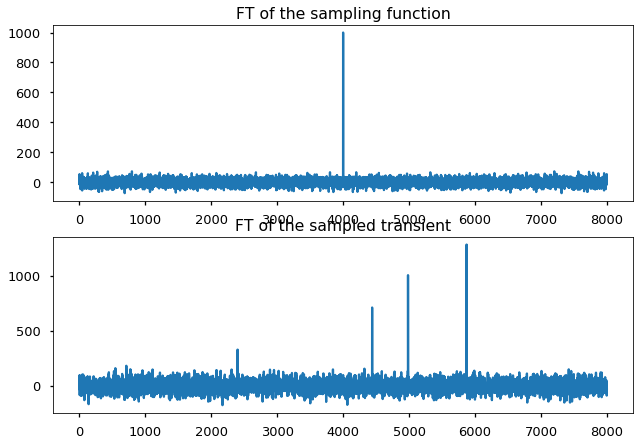

In [23]:
subplot(211)
plot(FT(x).real); title('FT of the sampling function')
subplot(212)
S = FT(x*fid); title('FT of the sampled transient')
plot(S.real)

This is called the **Sampling noise**

## let's measure/use this noise

In [26]:
def noise(data):
    b = data.copy()
    for i in range(10):
        b = b[ b-b.mean()<3*b.std() ]
    return b.std()
def SNR(data):
    return 20*log(abs(data).max()/noise(data))/log(10)
print ("noise : %.2f dB"%SNR(S))

noise : 25.37 dB


## spectral hard thresholding
by setting to zero points below a threshold level, we *somehow* reduce the spectral noise

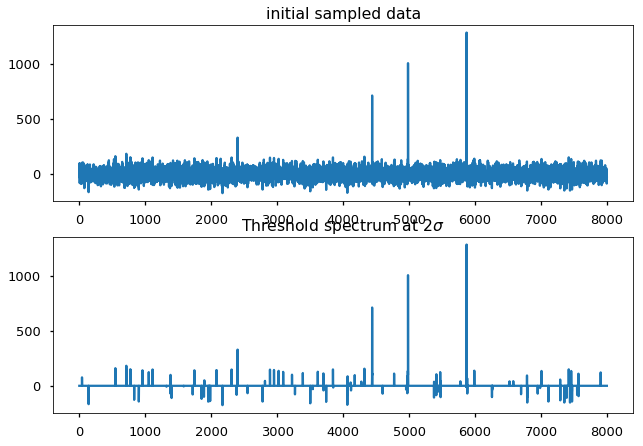

In [29]:
thresh = 2*noise(S)
aS = abs(S)
St = np.where(aS>thresh, S, 0)  # hard
subplot(211); plot(S.real); title('initial sampled data')
subplot(212); plot(St.real); title('Threshold spectrum at $2\sigma$');

## regenerating missing points
by inverse FT of this thresholded *noise reduced* spectrum we generate a new transient,
with *somehow* less noise.

Text(0.5,1,'back generated transient')

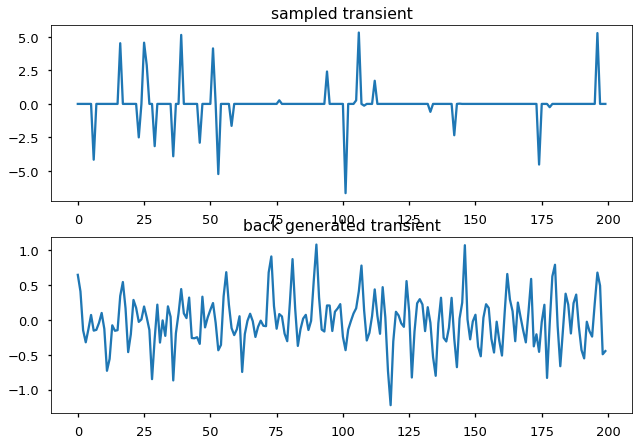

In [33]:
fidf = fft.ifft(fftshift(St))
subplot(211); plot((x*fid)[:200].real); title('sampled transient')
subplot(212); plot(fidf[:200].real); title('back generated transient')

notice the difference in intensity

## reinject experimental points

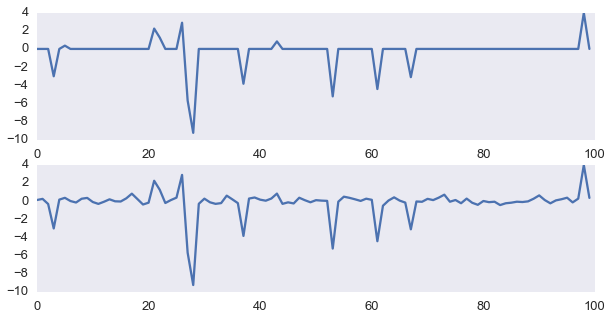

In [8]:
fid1 = fidf.copy()
fid1[sampling] = fid[sampling]
subplot(211)
plot((x*fid)[:100])
subplot(212)
plot(fid1[:100])

## sampling noise has been diminished

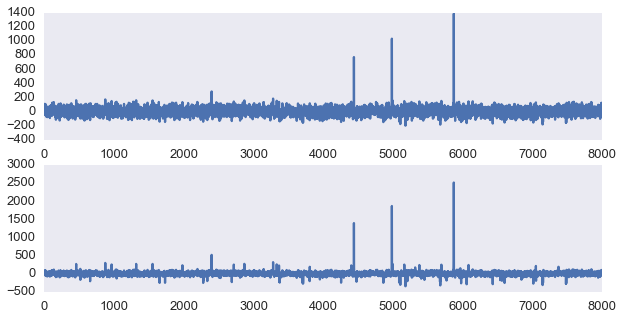

In [9]:
subplot(211)
plot(S)
subplot(212)
plot(FT(fid1))

## we can reiterate : Papoulis-Gershberg Algorithm

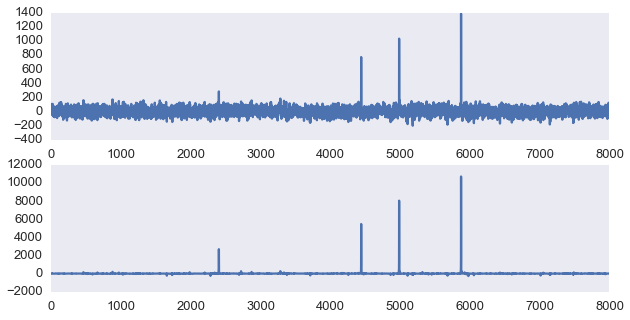

In [10]:
#Papoulis-Gershberg Algorithm
fid0 = x*fid
fidi = fid0.copy()
for i in range(50):
    Si = FT(fidi)
    thresh = 2*noise(Si)
    aSi = abs(Si)
    Sti = np.where(aSi>thresh, Si, 0)  # hard
    fidi = fft.ifft(fftshift(Sti))
    fidi[sampling] = fid0[sampling]
subplot(211)
plot(S)
subplot(212)
plot(FT(fidi))

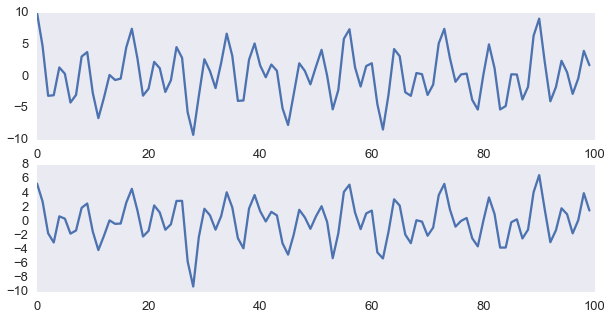

In [11]:
subplot(211)
plot(fid[:100])
subplot(212)
plot(fidi[:100])

## Compressed Sensing
all intermediate reconstructed spectra are **100% compatible with experimental data**.

 - Here, the hard thresholding is equivalent of minimizing the number of non-null points in the final spectrum
 - This is called the $\ell_0$ norm, however there are other norms $\ell_p$, it is a generalisation of the Cartesian norms, which is the $\ell_2$ norm:
 
 $$
 \ell_2(x) = \| x \|_2  = \sqrt{\sum x^2} = \left ( \sum x^2 \right)^\frac{1}{2} \\
 \ell_p(x) = \| x \|_p  = \sqrt[p]{\sum x^p} = \left ( \sum x^p \right)^\frac{1}{p} \\
 \ell_1(x) = \| x \|_1  = {\sum |x|} \\
 \ell_0 = \lim_{p \rightarrow 0} \ell_p \\
 \ell_\infty = \max(x)
 $$
 
 - strong arguments show that minimizing the $\ell_1$ norm is even better in certain situationw,
     - it would simply consists in replacing "hard-thresholding" by "soft-thresholding"
 - (Candès & Tao 2005) demonstrated that in certain conditions (held here), it can lead to an exact reconstruction.

## a circle in $\ell_p$ norm
position of the points $v=(x,y)$ where $\ell_p(v)=1$

![](files/cercles.png)

## different thresholding
- Hard thresholding

In [39]:
def HT(S, thresh):
    return np.where(S>thresh, S, 0)  # hard thresholding

- Soft thresholding

In [40]:
def ST(S, thresh):
    return np.where(S>thresh, S-thresh, 0)   # soft thresholding

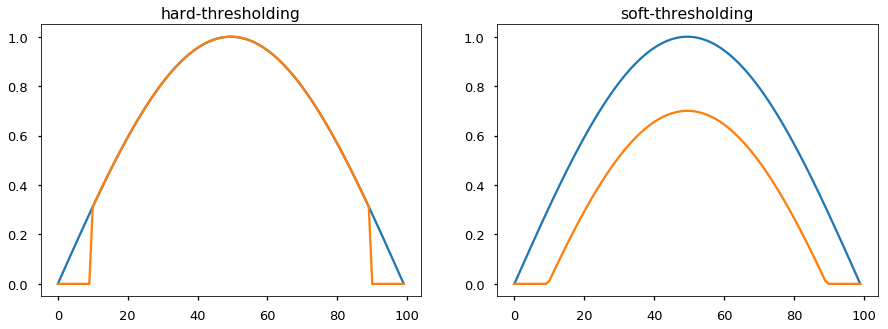

In [42]:
y = np.sin( np.linspace(0, np.pi, 100) )
plt.figure(figsize=(15,5))
plt.subplot(121); plt.plot(y); plt.plot(HT(y,0.3)); plt.title("hard-thresholding")

plt.subplot(122); plt.plot(y); plt.plot(ST(y,0.3)); plt.title("soft-thresholding");